# Rolling Sum

**TL;DR** This notebook demonstrates the performance improvement of using a numba JIT compiled algorithm for calculating rolling sum over the Pandas equivalent for some sample data.

In [1]:
from numba import jit
import pandas as pd
import numpy as np
import time

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib import rcParams
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = 16, 8

In [2]:
x = np.arange(30).astype(float)

In [3]:
s = pd.Series(x)
s[0] = np.nan
s[6] = np.nan
s[12:18] = np.nan
s[-1] = np.nan
s.values  # arbitrary but small input data

array([ nan,   1.,   2.,   3.,   4.,   5.,  nan,   7.,   8.,   9.,  10.,
        11.,  nan,  nan,  nan,  nan,  nan,  nan,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  nan])

In [4]:
s.rolling(window=3).sum().values  # pandas output

array([ nan,  nan,  nan,   6.,   9.,  12.,  nan,  nan,  nan,  24.,  27.,
        30.,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  57.,  60.,
        63.,  66.,  69.,  72.,  75.,  78.,  81.,  84.,  nan])

In [5]:
@jit(nopython=True)
def rolling_sum(x, window):
    
    n = x.shape[0]
    res = np.empty(n)
    
    rolling_sum = 0
    nans_in_window = 0
    
    for i in range(n):
        data_i = x[i]
        _nan_arrived = np.isnan(data_i)
        
        if _nan_arrived:
            nans_in_window = min(window, nans_in_window + 1)
        else:
            rolling_sum += data_i
            
        if i >= window:
            evict_i = x[i - window]
            _evict_nan = np.isnan(evict_i)
        
            if _evict_nan:
                if not _nan_arrived:
                    nans_in_window -= 1
            else:
                rolling_sum -= evict_i

            if nans_in_window == 0:
                res[i] = rolling_sum
                continue

        res[i] = np.nan
            
    return res

In [6]:
rolling_sum(s.values, 3)  # rolling_sum output

array([ nan,  nan,  nan,   6.,   9.,  12.,  nan,  nan,  nan,  24.,  27.,
        30.,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  57.,  60.,
        63.,  66.,  69.,  72.,  75.,  78.,  81.,  84.,  nan])

In [7]:
a = s.rolling(window=3).sum().values
b = rolling_sum(s.values, 3)
np.allclose(a, b, equal_nan=True)

True

In [14]:
def benchmarks():
    
    res = []
    
    for exponent in range(3, 7):
        n = 10**exponent
        data = np.arange(n).astype(float)
        data[3] = np.nan
        data[4] = np.nan
        data[-1] = np.nan
        s = pd.Series(data)
        
        window = int(max(1000, n * 0.1))  # cap window size at 1,000
        
        t1 = time.time()
        pandas_output = s.rolling(window=window).sum().values
        t2 = time.time()
        res.append(('pandas', n, (t2 - t1)))
    
        t1 = time.time()
        rsum_output = rolling_sum(s.values, window)
        t2 = time.time()
        res.append(('rolling_sum', n, (t2 - t1))) 
        
        assert np.allclose(pandas_output, rsum_output, equal_nan=True)
        
    return res

In [15]:
data = benchmarks()
df = pd.DataFrame(data, columns = ['fn', 'population', 'time (ms)'])

df['time (ms)'] = df['time (ms)'].apply(lambda x: x * 1000.) 
df = pd.pivot_table(df, values='time (ms)', index=['population'], columns=['fn'], aggfunc=np.sum)
df

fn,pandas,rolling_sum
population,,
1000,0.000000,0.000000
10000,0.982285,0.000000
100000,3.924847,0.980854
1000000,48.500061,3.925085


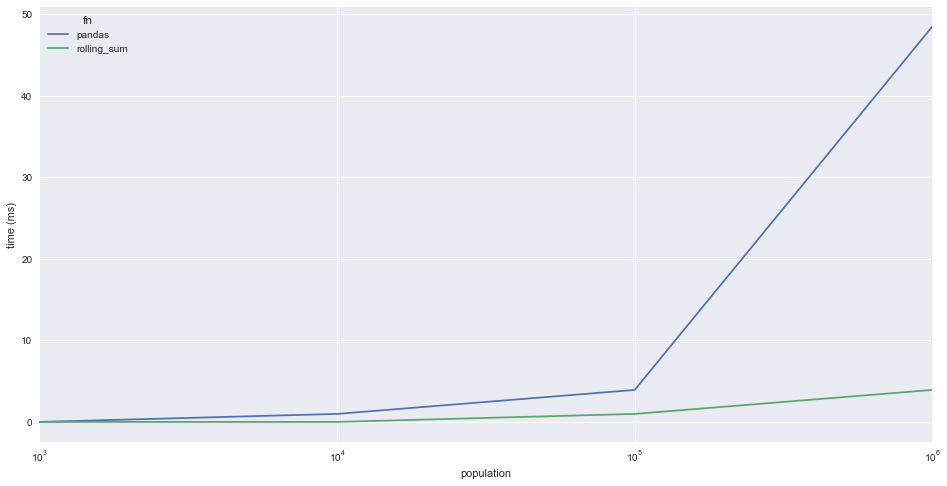

In [16]:
df.plot(logx=True)
plt.ylabel('time (ms)')